# Introduction

**Motivation**

Deep learning has brought a lot of improvement in several fields of AI: Natural Language Processing, Computer Vision, and Speech Recognition… However, Deep Learning usually requires a lot labelled data, which can be cumbersome, time consuming and expensive. This can be a limitation to bring those improvements to real-world applications. To tackle this issue two fields of study are of some interest: Unsupervised Learning and Few-shot Learning (FSL).
<br/>
<br/>

Unsupervised Learning aims to learn from unlabeled data, while FSL aims to learn from a small amount of data.
<br/>
<br/>

Humans have a great ability to learn from a small amount of data. Given a single picture of a person, it is fairly easy for a human being to recognize this person within a group of people on another picture. Few-shot Learning tries to bridge this gap between machines and humans ability to learn with few examples. It is therefore a very meaningful field of study in AI.
<br/>
<br/>


**The Omniglot Dataset**

The Omniglot dataset, is one of the most used dataset to evaluate few-shot learning algorithms. It is composed of 50 different alphabets, containing in total around 1600 characters. For each character, 20 hand-written square black and white images are given. 

**The K-shot N ways evaluation**

In FSL, the K-shot N ways task is a commonly used evaluation task to assess the performance of a model. The task can be defined this way:

*Given a query sample of a previously unseen class.
Given K samples of N previously unseen classes (the support set).
Match the query sample to the class it belongs to within the support set.*

Here is an visualization of a one-shot 9 ways:

 ![](https://sorenbouma.github.io/images/task_9.png)

The test image should be match to the class of the image on the top left in the support set.

**The Fellowship AI challenge**

It consist of performing one-shot 20 ways classification on Omniglot dataset using 30 alphabets for training and 20 alphabets for testing referring on the following script for sampling setup https://github.com/brendenlake/omniglot/blob/master/python/one-shot-classification/demo_classification.py 





# Methodology

**1.	Explore the dataset**

Challenge dataset : https://github.com/brendenlake/omniglot

The dataset is clean and well organized. Training and testing data are in 2 separate folders. The images are squared; hence our height/width ratio will be kept when pre-processing them. Resizing or transformation won’t bring distortion amoung them.

**2.	State of art**

Studying the recently published papers evaluations and their respective related work gave me a general view of the most advanced techniques to perform few-shot classification. We can mention: Matching Network, Prototypical Network and Relational Network. 

Those three methods have 2 things in common:
-	They start by embedding the high dimension samples into a lower dimensional space using some convolutions.
-	They both train and test by doing the K shot N ways task. Earlier approaches were using some different tasks at training resulting in a non optimal embedding.

Therefore, those seem to be 2 essential steps to implement.


**3.	Model choice**

Among the above methods, for one-shot 20 ways classification, in terms of [accuracy reported](https://arxiv.org/pdf/1711.06025.pdf), Relational Networks comes at the top (97.6%), followed by Protoypical Networks (96.0%) and finally Macthing Networks(93.8%). 
<br/>
<br/>
The Relational and Prototypical networks differ in the way they match the query image to the support set once in the embedding space. Prototypical network simply calculate the Euclidian distance of the query to each prototype: the mean of the K shot of each classes in the embedding space, and then associated the query the class with the smallest corresponding distance. Relational network instead learns a deep metric to do the matches.


I decided to try implementing a Prototypical network for the following reason: 
-	It is easier to understand and implement since it use a simple Euclidian distance, while keeping a good accuracy.
-	It allowed me to focus on the embedding function learning, while keeping the door open to learning a deep metric distance if wanted in the future.

# Setup 

This section install the required libs, upload  and arrange the data.

In [0]:
# required lib installation
!pip install torch torchvision line_profiler pillow # you made need to restart runtime : "Runtime > restart runtime"

In [0]:
# clone the challenge repo for sampling 
!git clone https://github.com/brendenlake/omniglot.git

** Folders arranging **

In [0]:
!mkdir data

In [0]:
!unzip -qq omniglot/python/images_evaluation.zip -d .

In [0]:
!unzip -qq omniglot/python/images_background.zip -d .

In [0]:
!mv images_background/* data

In [0]:
!mv images_evaluation/* data

In [0]:
# load my saved models and results. In case I do not want to retrain some models from scratch
!git clone https://github.com/bmetge/omniglot_20ways_1shot

**Few generals settings**

*ATTENTION* : Please notice I used the hyperparameters  of the paper implemantion from [github](https://github.com/jakesnell/prototypical-networks) provided by one of their fellow researcher. They does work well. I did so in order to focus on the one-shot 20 ways task, since the tuning of hyperparameter is already by itself a big topic in AI. 

In [0]:
root = "./data/"
background_path = "./omniglot/python/images_background.zip"
evaluation_path = "./omniglot/python/images_evaluation.zip"

# settings from the paper implemantation
learning_rate=0.001
lr_scheduler_step=20
lr_scheduler_gamma=0.5

print_freq=1 # used to define printing frequency while training

device= "cuda:0" # put cpu here if you want to use your cpu instead

LOAD_MODEL = True

In [0]:
# libs importing
import torch
import torch.nn as nn
import torchvision
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from os.path import join as pj
import os
import zipfile
from tqdm import tqdm
import numpy as np
from itertools import chain
from sklearn.manifold import TSNE
from google.colab import files
from line_profiler import LineProfiler



%matplotlib inline
%load_ext line_profiler

**utils**

In [0]:
import pickle
def save_object(obj, filename):
    '''
        save an object. Useful to keep a track of some results.
        # arguments
            obj: python object to save
            filename: name of the expected pickle file
    '''
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    '''
        Load a save object at filename
    '''
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as input:
                return pickle.load(input)
        else:
            return None
    except Exception as e:
        print("Error while loading object :" + str(e))
        return None
        

# A computationally efficient calculation of the loss function

I managed to provide a more computationally efficient calculation of the loss function, which can be useful in real world application. 
<br/>
<br/>
Below, we compare the speed of the original fonction "euclidean_dist" from the [github repo](https://github.com/jakesnell/prototypical-networks) and my own fonction "ec". On the same test  the "euclidian_dist" tooks 2.64847 seconds to run where my "ec" fonction took  1.19781 seconds.  **It is more than 2 times faster.**, most of the time.

I applied the following formula on [euclidiean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between vectors:

![Texte alternatif…](https://wikimedia.org/api/rest_v1/media/math/render/svg/95db6f6d65948f1d0086ac0f6f59a22a92627334)

It avoids copying m times x and n times y likes in the provided git repo and make use of broadcasting. 

In [0]:
# original
def euclidean_dist(x, y):
    '''
        Compute euclidean distance between two tensors
    '''
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d) # this will copy m times x
    y = y.unsqueeze(0).expand(n, m, d) # this will copy n times y
    return torch.pow(x - y, 2).sum(2)

# boosted with broadcasting
def ec(x,y):
    xy = x.mm(y.t())  
    xnorm = (x*x).sum(1).unsqueeze(1)  
    ynorm = (y*y).sum(1).unsqueeze(0)
    return (xnorm + ynorm - 2*xy)

In [0]:
x = torch.from_numpy(np.random.rand(10000,1))
y = torch.from_numpy(np.random.rand(10000,1))

In [0]:
lp = LineProfiler()
lp_wrapper = lp(euclidean_dist)
lp_wrapper(x,y)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 2.64847 s
File: <ipython-input-186-1d78da456e0d>
Function: euclidean_dist at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def euclidean_dist(x, y):
     2                                               '''
     3                                                   Compute euclidean distance between two tensors
     4                                               '''
     5         1         13.0     13.0      0.0      n = x.size(0)
     6         1          3.0      3.0      0.0      m = y.size(0)
     7         1          1.0      1.0      0.0      d = x.size(1)
     8         1        624.0    624.0      0.0      x = x.unsqueeze(1).expand(n, m, d) ## on copie m fois x
     9         1         23.0     23.0      0.0      y = y.unsqueeze(0).expand(n, m, d) ## on copie n fois y
    10         1    2647811.0 2647811.0    100.0      return torch.pow(x - y, 2).sum(2)  ## 



In [0]:
lp = LineProfiler()
lp_wrapper = lp(ec)
lp_wrapper(x,y)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 1.19781 s
File: <ipython-input-186-1d78da456e0d>
Function: ec at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def ec(x,y):
    14         1     289988.0 289988.0     24.2      xy = x.mm(y.t())  
    15         1        298.0    298.0      0.0      xnorm = (x*x).sum(1).unsqueeze(1)  
    16         1        206.0    206.0      0.0      ynorm = (y*y).sum(1).unsqueeze(0)
    17         1     907318.0 907318.0     75.7      return (xnorm + ynorm - 2*xy)



# Model implemantation


To be able to augment the model capacity I have written below two different convolution blocks. 
1. "conv_block_shallow" is has describe in the paper conv-bn-relu-pool. 
2. "conv_block_deep" which is a conv-bn-relu-conv-bn-relu-pool block.

Results are discussed below in the model validation section.

In [0]:
def conv_block_shallow(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

def conv_block_deep(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.MaxPool2d(2)
    )


def get_model(model_path, conv_block=conv_block_deep):
    '''
        util fonction to upload a previously trained model if needed.
    '''
    if os.path.exists(model_path):
        try:
            model = ProtoNet(conv_block=conv_block).to(device)
            model.load_state_dict(torch.load(model_path))#, map_location={'cuda:0': 'cpu'}))   # uncomment when you work on cpu.
            return model
        except Exception as e:
            print("Error while loading model :" + str(e))
            return None
    else:
        return None
    
 

class ProtoNet(nn.Module):
    '''
    Prototyical network as described in the reference paper,
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64, conv_block=conv_block_deep):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim,   hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

**Fonctions for training and testing**

In [0]:
def ec(x,y):
    xy = x.mm(y.t()) 
    xnorm = (x*x).sum(1).unsqueeze(1)
    ynorm = (y*y).sum(1).unsqueeze(0)
    return (xnorm + ynorm - 2*xy) 
 
def lossfunc(proto, query, lbl):
    dists = ec(query, proto)
    loss  = torch.nn.CrossEntropyLoss()(-dists, lbl)
    acc   = (dists.min(1)[1]==lbl).float().mean().item()
    return loss, acc

def test_model(model, ds):
    '''
        Test the model with the prototypical learning algorithm
    '''
    accuracy = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

def get_loss_acc(model, ds):
    '''
        Returns loss and accuracy for model : model , used with ds dataset.
    '''
    accuracy = []
    losses = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        loss, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
        losses.append(loss)
    return losses, accuracy

def train_epoch(model, optim, ds):
    '''
        Train the model with the prototypical learning algorithm for one epoch.
    '''
    model.train()
    ds._generate_split()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    losses, accuracies = [],[]
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        loss, acc = lossfunc(proto, query, lbl)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        accuracies.append(acc)
    return losses, accuracies

def train_model(model, optim, ds_train, ds_test, lr_scheduler, nepochs=10, print_freq=2):
    '''
        Train the model with the prototypical learning algorithm on all epoch.
    '''
    losses, tr_acc, te_acc = [],[],[]
    for epoch in range(nepochs):
        loss, acc = train_epoch(model, optim, ds_train)
        losses.append(loss)
        tr_acc.append(acc)
        print('Training Avg Loss: {}, Avg Acc: {}'.format(np.mean(loss), np.mean(acc)))
        if epoch % print_freq==0:
            acc = test_model(model, ds_test)
            te_acc.append(acc)
            print('Test Accuracy: {}'.format(np.mean(acc)))
        lr_scheduler.step()
    return losses, tr_acc, te_acc

# Data loading 

In [0]:
def train_split():
    '''
        Returns the alphabets folders name specify for training in the challenge.
    '''
    with zipfile.ZipFile(background_path) as f:
        x = set(map(lambda x:x.filename.split("/")[1], f.filelist))
        return list(filter(lambda x:len(x)>0, x))

def test_split():
    '''
        Returns the alphabets folders name specify for testing in the challenge.
    '''
    with zipfile.ZipFile(evaluation_path) as f:
        x = set(map(lambda x:x.filename.split("/")[1], f.filelist))
        return list(filter(lambda x:len(x)>0, x))

def load_data(classes):
    """
        Load the file data in memory 
        (without any operation on it to be able to perform different kind of transformation on it later if needed)
    """
    x, y, cur = [],[],0
    for cl in tqdm(classes):
        for ch in os.listdir(pj(root, cl)):
            base = pj(root, cl, ch)
            for im in filter(lambda x:x.endswith(".png"), os.listdir(base)):
                im = read_image(pj(base, im))
                x.append(im)
                y.append(cur)
            cur+=1
    y = torch.LongTensor(y).to(device)
    return x,y

def read_image(fp, size=(28,28)):
    '''
        reads an image
    '''
    im = Image.open(fp)
    im = im.convert("L")
    im = ImageOps.invert(im)
    return im.resize(size)
    return im


def transform_dataset(images, aff=lambda x:x):
    '''
        apply the transformation on the dataset ( used for data augmentation)
    '''
    x = [transform_image(im, aff) for im in images]
    return torch.cat(x).float().to(device)

def transform_image(im, aff):
    '''
        apply the transformation aff on im ( used for data augmentation)
    '''
    im = aff(im)
    im = im.resize((28,28))
    im = np.array(im)
    im = torch.from_numpy(im)
    return im.unsqueeze(0)

# Belows fonction are for setting up which data images to used on one batch testing case.
def get_batch_ids(n_class, n_way, k_shot, n_samp=20):
    cid  = np.random.choice(n_class, n_way, replace=False).repeat(k_shot) 
    offs = np.concatenate([np.random.choice(n_samp, k_shot, replace=False) for i in range(n_way)])
    return cid*n_samp + offs

def sample_set_ids(ids):
    return ids[::2], ids[1::2]
    
def index_bid(x, support, query):
    return x[support], x[query]

def sample_batch(x, n_class, n_way, k_shot, n_samp=20):
    bid = get_batch_ids(n_class, n_way, k_shot, n_samp)
    support, query = sample_set_ids(bid)
    return index_bid(x, support, query)



class OmniGlotDs():
    '''
        Omniglot dataset class. N-WAY default is 60 as it is specify in the paper to be better at training time.
    '''
    def __init__(self, classes, k_shot=5, n_way=60, n_samp=20, n_iter=1000, transform=None):
        self.x,self.y = load_data(classes)
        self.n_class = len(self.y.cpu().unique())
        self.n_iter = n_iter
        self.k_shot = k_shot
        self.n_way  = n_way
        self.n_samp = n_samp
        self.transform = transform if transform else lambda x:x
        self._generate_split()
        
    def _generate_split(self):
        self.X = transform_dataset(self.x, self.transform)
        
    def sample(self):
        return sample_batch(self.X, self.n_class, self.n_way, 
                            self.k_shot*2, self.n_samp)
    
    def __iter__(self):            
        for i in range(self.n_iter):
            yield self.sample()
            
    def __len__(self):
        return self.n_iter

In [0]:
# loadling the classes splits
test_class = test_split()
train_class = train_split()

# params
nepochs = 50
nepochs = 2
print_freq=1
device="cuda:0" #device="cpu"  -> choose here

# Data augmentation visualization
Data augmentation is use to boost a model capacity at training time.
<br/>
<br/>
In the Prototypical Network paper, they do some data augmentation of +90, -90 and 180 degrees on each image. But since a "M" becomes a "W" when you flip it, I did instead some more light affine transformation to keep the augmented characters always on the same side. 
<br/>
<br/>
This section provide a visualization of my data augmentation effect. Each time we run a batch we apply a random tranformation on it and you can see on the last cell that it looks like more images written by more persons of the same character. 




In [0]:
test_class = test_split()

In [0]:
ds_test = OmniGlotDs(test_class, k_shot=1, n_iter=1000)

100%|██████████| 20/20 [00:03<00:00,  4.34it/s]


In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1), resample=Image.BILINEAR)

In [0]:
a = ds_test.x[0]

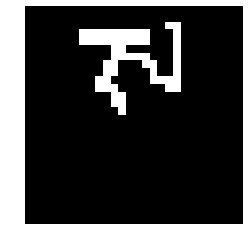

In [0]:
#plt.style.use("dark_background")
plt.axis('off')

plt.imshow(np.array(a), cmap="gray")

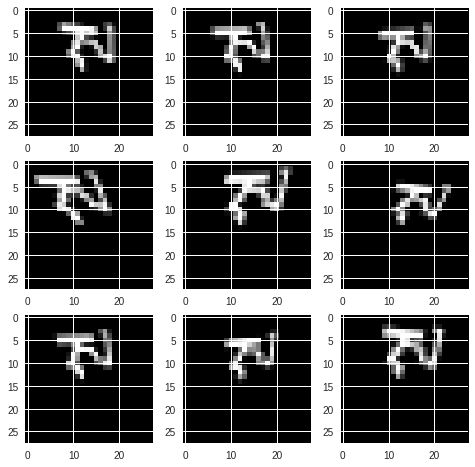

In [0]:
#plt.axis('off')

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = Aff(a)
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.array(img), cmap='gray')
plt.show()

# Model validation  

In this section we validate our model by testing it's accuracy. We test 3 cases:


1.   No  data augmentation with conv_block_shallow : where we see some overfitting issue
2.   Data augmentation with conv_block_shallow: where data augmentation seems to solve the overfitting issue, but our testing accuracy seems to now indicates underfitting.
3.   Data augmentation with conv_block_deep : where the underfitting issue is solved thanks to a better model capacity. 

Plots of the results are below. We will see that option 3 works the best.





In [0]:
# no data augmentation 
no_augmentation  = lambda x:x
no_augmentation.__name__ = "no_augmentation"

# data augmentation
yes_augmentation = Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
yes_augmentation.__name__ = "yes_augmentation"

results = {}
models = {}

n_iter = 1000
nepochs = 50
print_freq = 1

for Aff in [no_augmentation, yes_augmentation]:
        # Testing the 2 conv blocks
        for conv_block in [conv_block_shallow, conv_block_deep]:
            key_path = Aff.__name__ + "_" + conv_block.__name__ + "_" + str(nepochs) + "_epochs"
            print("STATUS :   " + key_path)
            model_path_validation = "./omniglot_20ways_1shot/saved_models/model_validation_" + key_path
            result_pickle_name = "./omniglot_20ways_1shot/saved_results/result_validation_" + key_path + ".pkl"
            model_nways = get_model(model_path_validation,conv_block=conv_block)
            if model_nways:
                print('MODEL UPLOADED')
                models[(key_path)] = model_nways
                result = load_object(result_pickle_name)
                if result:
                    print('Results successfully retrived')
                    results[(key_path)] = result
                else:
                    print("Enable to load results !!!")
            else:
                print('MODEL NOT FOUND , creating one...')
                ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter)
                ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)
                model = ProtoNet(conv_block=conv_block).to(device)
                
                # learning rate settings ( as in PN paper)
                optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                               gamma=lr_scheduler_gamma,
                                                               step_size=lr_scheduler_step)
                # training
                losses, tr_acc, te_acc = train_model(model, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
                results[(key_path)] = losses, tr_acc, te_acc
                models[(key_path)] = model
                
                # saving the model
                try:
                    print("Saving the model " + Aff.__name__ + conv_block.__name__)
                    torch.save(model.state_dict(), model_path_validation)
                    files.download(model_path_validation)
                except Exception as e:
                    print("Exception while saving model :" + str(e))
                    
                # saving the result
                try:
                    print("Saving the results " + Aff.__name__ + conv_block.__name__)
                    save_object(filename=result_pickle_name,obj=results[(key_path)])
                    files.download(result_pickle_name)
                except Exception as e:
                    print("Exception while saving results :" + str(e))


In [0]:
# prepare for plotting
res = []
models_ = []
for Aff in [no_augmentation, yes_augmentation]:
    for conv_block in [conv_block_shallow, conv_block_deep]:
        key_path = Aff.__name__ + "_" + conv_block.__name__ + "_" + str(nepochs) + "_epochs"
        res.append(results[(key_path)])        
        models_.append(models[(key_path)]) 

Final accuracy obtain: 91.01500095725059 / 100 % 



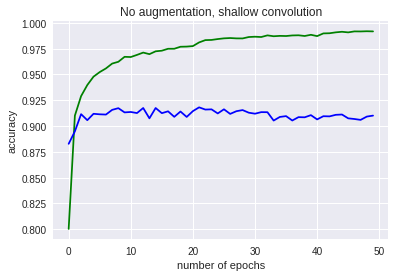

In [0]:
# No augmentation, shallow 
x = res[0]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

First thing to notice, we reach more than 90% accuracy, so the model can be considered as working.

In green, we can see the training curve. In blue the testing curve. (we will keep this colors for all the following)

The training curve almost reach 100% accuracy at the end, while the testing curve stays around 91% . This clearly indicates a **overfitting** issue.


Final accuracy obtain: 92.92000084519387 / 100 % 



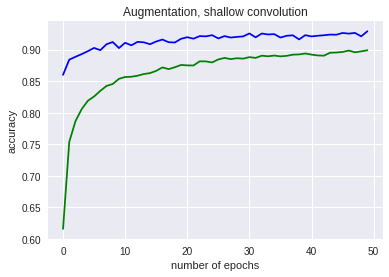

In [0]:
# Augmentation, shallow

x = res[2]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('Augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

First thing to notice , the overfitting issue seems solved. However, now training accuracy stays below 90%, which indicates that know we are infact **underfitting** a bit. 
<br/>
<br/>
*remark: the testing curves is above the training curve, which can be surprising , but it is because , as stipulated above and in the paper, the training is done on 60 ways while the testing on 20 ways to get better results. Matching an object within 60 classes, is obviously more difficult than in 20, thus the above result.* 

Final accuracy obtain: 93.15500075817108 / 100 % 



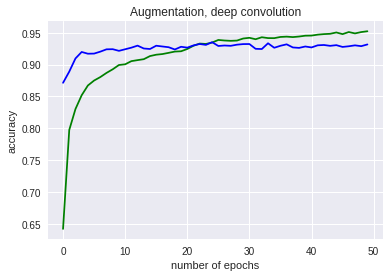

In [0]:
# Augmentation, deep ==> decent result !!

x = res[3]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('Augmentation, deep convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

By combining Augmentation and deep convolution block , our error drops below 7% and there is no sign of either overfitting or underfitting.

# Discussion

In the paper for prototypical network, they reach a 96 % accuracy where we reach 93%.

A potential explanation is that we are using different split. They use 1200 classes for training and 423 classes for testing. Our split use 964 classes for training and 659 for testing. Moreover, the 1200 classes they use in the paper are randomly selected from all the alphabet. In our split, we use separate alphabet for training and testing ! We can imagine that within a single alphabet there is similarities that can be learned at training in their case, but not in ours since our testing set is fully composed of unseen alphabet.

# Test on the challenge script runs

The script in the challenge  repo reach [an average error of 38.75%](https://www.kaggle.com/baptistemetge/omniglot-fellowai) on the small  set contain here : https://github.com/brendenlake/omniglot/blob/master/python/one-shot-classification/all_runs.zip


This section test our above model on this exact same set. We reach 89.5% of accuracy.

In [0]:
# setting up the data from challenge script
!mkdir data_challenge

In [0]:
!unzip -qq ./omniglot/python/one-shot-classification/all_runs.zip -d data_challenge

In [0]:
# loading the above last model (session had crash in between and deadline is coming :/ )
LOAD_MODEL = True
challenge_model_path = "./omniglot_20ways_1shot/saved_models/model_validation_yes_augmentation_conv_block_deep_50_epochs"

if LOAD_MODEL:
    challenge_model = get_model(challenge_model_path)
    if challenge_model:
        print('MODEL UPLOADED CORRECTLY !')
    else:
        print('SORRY ! MODEL NOT FOUND. Please make sure your challenge_model_path is correct or train one with the above section')
else:
    try:
        challenge_model = model_optim
    except Exception as e:
        print("please make sure you have run the above section to get your optim or load one setting LOAD_MODEL=True")

MODEL UPLOADED CORRECTLY !


In [0]:
# Splits of the challenge  sampling
class ChallengeDataset(object):
    def __init__(self, root, nsamp):
        self.runs = []
        self.n_way = 20
        self.k_shot = nsamp
        self.base = root
        
        for run in os.listdir(root):
            fp = pj(root, run, "class_labels.txt")
            train, test = self._read_run(fp)
            self.runs.append([train, test])
            
    def __len__(self):
        return len(self.runs)
    
    def __iter__(self):
        for run in self.runs:
            yield run
            
    def _read_run(self, fp):
        with open(fp) as f:
            content = f.read().splitlines()
            pairs = [line.split() for line in content]
            test_files  = [pair[0] for pair in pairs]
            train_files = [pair[1] for pair in pairs]
        
        im = [read_image(pj(self.base, im)) for im in test_files]
        train = transform_dataset(im).view(-1,28,28)

        im = [read_image(pj(self.base, im)) for im in train_files]
        test = transform_dataset(im)
        
        return train, test
    
def read_image(fp, size=(28,28)):
    """
        read the image under fp filepath and resize it.
    """
    im = Image.open(fp)
    im = im.convert("L")
    im = ImageOps.invert(im)
    return im.resize(size)

    
def test_challenge(model, ds_test):
    '''
        Testing ont the challenge provided script same set
    '''
    accuracy = []
    model.eval()
    n_way = ds_test.n_way
    k_shot = ds_test.k_shot
    lbl = torch.from_numpy(np.arange(n_way)).to(device)
    print(lbl.size())
    for xim, yim in tqdm(ds_test):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds_test.n_way, ds_test.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

In [0]:
ds_challenge = ChallengeDataset("./data_challenge", 1)
challenge_acc = test_challenge(challenge_model, ds_challenge)
print("Accuracy in the challenge test = " + str(100*np.mean(challenge_acc)) + " % !")


100%|██████████| 20/20 [00:00<00:00, 169.93it/s]

torch.Size([20])
Accuracy in the challenge test = 89.50000137090683 % !


# Discussion

Provided script had 38.75 % and we managed to get 89.5%.

One could wonder, why above we reach 93% with the same model. An potential explanation is that the all_runs.zip contains only 20 folders providing each 20 query images and a support set. So we are running only 400 times the test, which might not be enough to get a proper averge of the accuracy.

# Going further

The following section explore some ways to go further in trying to improving the results.  It only shows and explain the ideas, but no official conclusion will be made from the result, as it would require to diving more deeply in the study and run more test.

## Test Time augmentation

K shot N ways classification gives much better results when K gets bigger. In our case, unfortunatly : K = 1. But we can emulate a bigger K by using data augmentation but at test time. It means, we will generate K affine transformation on each support set images at test time. 


Below we show a small test using our "best" model and with several value of N.

In [0]:
# Test time augmentation
def transform_dataset_multi(images, aff=lambda x:x, nsamp=5):
    x = [transform_image_multi(im, aff, nsamp) for im in images]
    return torch.cat(x).float().to(device)

def transform_image_multi(im, aff, nsamp):
    im = [transform_image(im, aff) for i in range(nsamp)]
    im = torch.cat(im)
    return im.unsqueeze(0)


def index_bid_multi(x, y, support, query):
    return x[support].view(-1, 28, 28), y[query].view(-1, 28, 28)

def sample_batch_multi(x, y, n_class, n_way, k_shot, n_samp=20):
    bid = get_batch_ids(n_class, n_way, k_shot, n_samp)
    support, query = sample_set_ids(bid)
    return index_bid_multi(x, y, support, query)

class OmniGlotDsMulti():
    def __init__(self, classes, k_shot=5, n_way=60, n_samp=20, n_trans=10, n_iter=100, 
                 query_transform=None, proto_transform=None):
        """ 
            Todo.
        """
        self.x,self.y = load_data(classes)
        self.n_class = len(self.y.cpu().unique())
        self.n_iter = n_iter
        self.k_shot = k_shot
        self.n_way  = n_way
        self.n_samp = n_samp
        self.n_trans= n_trans
        self.query_transform = query_transform if query_transform else lambda x:x
        self.proto_transform = proto_transform if proto_transform else lambda x:x
        self.generate_split()
        self.generate_query_split()
        
    def generate_query_split(self):
        self.queries = transform_dataset(self.x, self.query_transform)
        
    def generate_split(self):
        self.support = transform_dataset_multi(self.x, self.proto_transform, self.n_trans)
        
    def sample(self):
        return sample_batch_multi(self.support, self.queries,
                                  self.n_class, self.n_way, 
                                  self.k_shot*2, self.n_samp)
    
    def __iter__(self):            
        for i in range(self.n_iter):
            yield self.sample()
            
    def __len__(self):
        return self.n_iter

In [0]:
def test_multi(model, ds):
    '''
        Run the test with test time augmentation:
         -> dataset shoud be = OmniGlotDSMulti
    '''
    accuracy = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.n_trans
    lbl = torch.from_numpy(np.arange(n_way)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(n_way, k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
N_TRANS = [5, 10, 15, 20, 25, 30]

n_iter = 1000
print_freq=1

#MODEL TO USE
model_ntrans = models_[-1]  # HERE SELECT THE MODEL YOU WANNA USE
test_acc_trans = []

#loading train set
ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter)#

for NTRA in N_TRANS:
    
    #loading test set
    ds_test  = OmniGlotDsMulti(test_class,query_transform=None, proto_transform=Aff, k_shot=1, n_way=20, n_iter=n_iter,n_trans=NTRA)
    te_acc = test_multi(model_ntrans,ds_test)
    test_acc_trans.append(np.mean(te_acc))

Text(0,0.5,'acc')

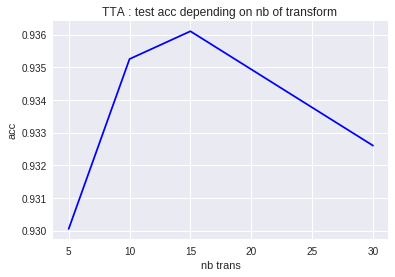

In [0]:
plt.plot(N_TRANS, test_acc_trans, color='blue')
plt.title("TTA : test acc depending on nb of transform ")
plt.xlabel('nb trans')
plt.ylabel('acc')

**discussion** 

We see that doing so we reach 93.6 % accuray with 15 transformations at test time (our last best result was 93.1% when without TTA). Though, we tested only a few N values, so we can't really conclude on which value for N transformation is the best, butit seems to improve our model.

### Vizualising TTA effect

This section provides a visualization of what is happening with TTA.

In [0]:
colors = np.random.rand(20, 3)

def print_tsne(support, query, figsize=(10,10)):
    nclass = query.size(0)
    nsamp = int(support.size(0) / nclass)
    if "cuda" in device:
        data_points = torch.cat([support, query]).cpu().detach().numpy()
    else:
        data_points = torch.cat([support, query]).detach().numpy()
    points = TSNE(2).fit_transform(data_points)
    
    support_p = points[:nclass*nsamp]
    query_p = points[nclass*nsamp:]
    
    fig, axes = plt.subplots(1,1, figsize=figsize)
    for i in range(nclass):
        axes.scatter(support_p[i*nsamp:(i+1)*nsamp, 0], support_p[i*nsamp:(i+1)*nsamp,1], 
                     color=colors[i], marker="o", alpha=0.5)
        axes.scatter(query_p[i:(i+1),0], query_p[i:(i+1),1], color=colors[i], 
                     marker="v", linewidths=.5, edgecolors="k", alpha=1)

def plot_test_sample(model, ds):
    model.eval()
    n_way = ds.n_way
    k_shot = ds.n_trans
    
    for xim, yim in ds:
        break
        
    inp = torch.cat([xim,yim]).unsqueeze(1)
    out = model(inp)
    
    support = out[:n_way*k_shot]
    query = out[n_way*k_shot:]
    print_tsne(support, query)

In [0]:
# Avec data augmentation
n_trans = 10
ds_te = OmniGlotDsMulti(test_class,  proto_transform=Aff, 
                          k_shot=1, n_iter=1, 
                          n_way=20, n_trans=n_trans)

 TTA effect visualization with TSNE 



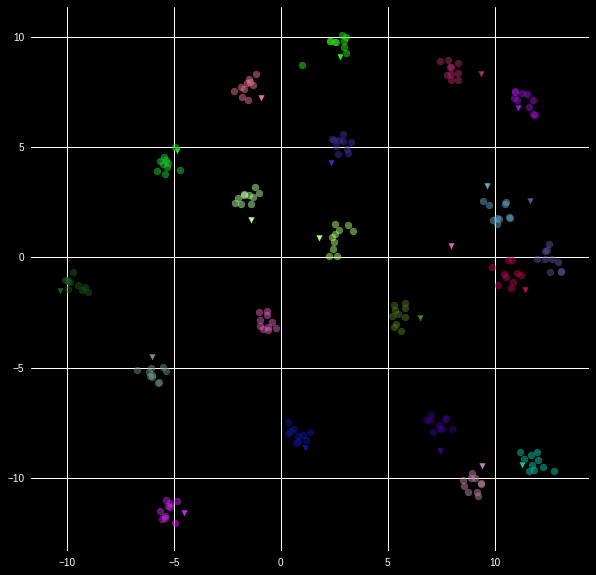

In [0]:
plt.style.use("dark_background")
print(' TTA effect visualization with TSNE \n')
plot_test_sample(challenge_model, ds_te)

**Explanation**

We used TNSE to project our data in 2 dimensions. Rounds of each color are the N generated images of a single support image at testing. The color corresponding triangle show the corresponding query image. Those clusters allows more chances for a query to be close to the support set it belongs to than if they was only one single support image per character (one round of each color)

## Few other ideas

### Changes N ways value at training time

**ACCORDING to the [paper](http://papers.nips.cc/paper/6996-prototypical-networks-for-few-shot-learning.pdf)** : *"We trained Prototypical Networks using Euclidean
distance in the 1-shot and 5-shot scenarios
with training episodes containing 60 classes
and 5 query points per class. We found that it
is advantageous to match the training-shot with
the test-shot, and to use more classes (higher
“way”) per training episode rather than fewer.""*


It would be interesting to verify this value is a good choice and maybe test has well even higher values.

### Learn a deep metric

Get some inspiration from the Relation network, to find a better metric for the loss calculation than the euclidean distance.